High level story:

1. word cloud and barriers number histogram - what barriers do learners face? 
2. correlation, how do these barriers relate to each other? can we explore these relationships in more detail?
3. Likert diagrams to explore differences between programs/ regions, highlight interesting findings
4. visualise the flow of grads from bootcamp to 6months post-bootcamp. does placement speed vary per region? per programme? and how do the barriers factor in?

Questions for clarification: 
- what barriers/ metrics is the feature "barriers value" based on?


# Generation Exploratory Data Analysis
####   Megan Guidry | March 2024 

In [1096]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS

import plotly.graph_objects as go

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from pandas.api.types import CategoricalDtype
from scipy import stats

## Objective

Generation UK&I has a mission to get disadvantaged people into sustainable careers that would otherwise be unattainable. This Jupyter notebook explores the demographics and barriers faced by Generation learners.

#### Assumptions
I am assuming this audience values diversity in tech. My audience is interested to understand the challenges that arise when recruiting, training, and employing people who have various employment barriers to overcome. This analysis could be used to motivate improvements to operational processes such that Generation:
- Recruits learners with a genuine need for carrer support
- Trains learners sufficiently for their chosen tech career, and
- Supports graduates through to employment as quickly as possible after bootcamp graduation.

#### Guiding Questions 
1. How many barriers does the typical Generation lerner face? What do these barriers look like?
2. How do these barriers correlate with each other and with other learner features at an individual level? How can this data help Generation staff better support Generation learners while on bootcamp and during placement phase?
3. What does the distribution of these barriers look like at a program or regional level. Is it possible to identify any trends?
4. Does gender impact employment outcomes? Are there any interesting trends in the genders of the learners?

#### The Dataset

- The original dataset has 2602 observations. Each observation represents a learner that has been admitted onto a Generation UK&I bootcamp.
- This analysis will focus on tech bootcamps. After removing non-tech bootcamps from the dataset there are 1917 observations.
- The original dataset included only one cohort of approximately 25 learners based in Dublin. The rest are based in the UK. I have removed the Dublin cohort from this analysis.
  
**Program Names:**
- Technology - Cloud Operations Engineer
- Technology - Data Engineering
- Data Analytics
- IT Support
- Tech Talent Accelerator - Software Engineering
- Google Cloud

## Data Cleaning

In [1097]:
gen_df = pd.read_csv("Gen_Data/ANON_gen_data_March2024.csv")

##### Note: cleaning specific features ahead of heatmap correlation analysis

There are quite a lot of missing data in this dataset. for that reason I have carefully selected features that are as complete as possible to use for the correlation analysis. The features that were excluded from this portion of the EDA due to high numbers of NaN valuse include:

- is_low_socio_econ
- is_unempl_12+_mths
- is_unemployed_pre_gen
- Job_start_speed
- socioeconStatusMap
- Average Score - Soft Skills
- Average Score - Technical Skills
- IMD Decile

With more data the above features could be included in correlation analysis.

Features included in correlation analysis:
- asylumSeeker*
- Barriers value
- Education level
- has_degree
- Has_dependents*
- Is_30_or_over
- Is_disabled
- is_EAL
- is_ethnic_minority*
- is_LGBTQ+*
- is_lone_parent*
- Days Since Cohort Graduation
- Total Days Absent
- Total Days Late
- gender_bool
- learnerspecialneeds_bool

The features that have a star need data imputed. For most of these features (asylumSeeker, Has_dependents, is_ethnic_minority, is_LGBTQ, is_lone_parent) replaceing a null value with 0 is sufficient. This is because assigning a value of zero is equivalent to assuming this individual does not have this barrier. The error and bias from incorrectly lableing someone as having the barrier is greater than if we incorrectly lable someone as lacking the barrier. Aditionally, removing the rows completely would remove valuable data from other columns.

## Exploratory Data Analysis

#### 1. What barriers do Generation UK & I learners face?

In this analysis we look specifically into 15 different situational or demographic barriers. 
-   asylumSeeker                            
-   Education level                         
-   gender                                  
-   has_degree                              
-   Has_dependents                          
-   IMD_decile                              
-   Is_30_or_over                           
-   Is_disabled                            
-   is_EAL                                 
-   is_ethnic_minority                      
-   is_LGBTQ+                               
-   is_lone_parent                         
-   is_low_socio_econ                       
-   is_unempl_12+_mths                      
-   is_unemployed_pre_gen

NOTE: The feature "Barriers value" is a count of all the barriers metrics that describe an individual learner.            

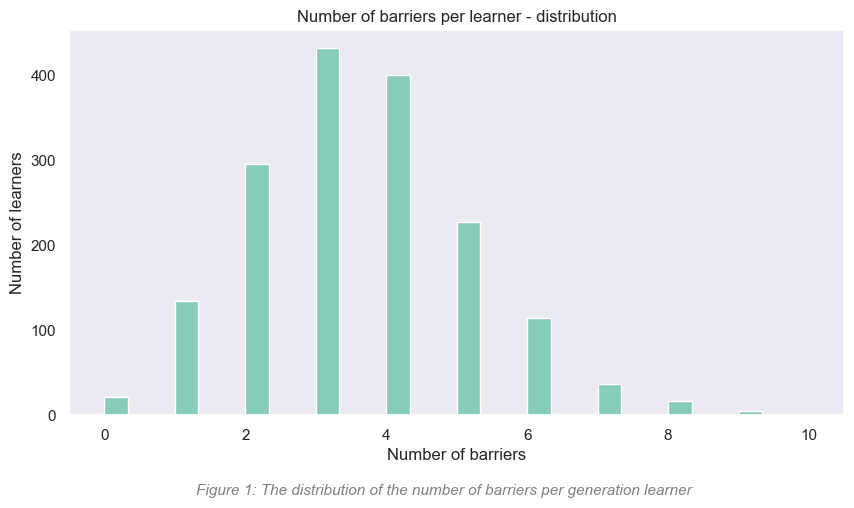

In [1246]:
plt.figure(figsize=(10, 5))
sns.set_theme
sns.set_style("dark")
sns.set_palette("Set2")

sns.histplot(data= gen_df, 
             x="Barriers value"
            )

plt.title("Number of barriers per learner - distribution")
plt.xlabel("Number of barriers")
plt.ylabel("Number of learners")
plt.rcParams.update({'font.size': 14})

# Figure caption:
txt="Figure 1: The distribution of the number of barriers per generation learner"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=11, color="0.5", style='italic')
plt.show()

#### What special needs are most common among learners
The feature "learnerSpecialNeedsDetails captures important information about the special needs that particular grad has. This is recorded by a generation staff member during the admissions process and helps staff understand how best to support this individual.

Note: Most learners do not have any special needs so this data is reflecting the minority that have disclosed this information to Generation.

In [1140]:
# Learner special needs wordcloud:
@interact
def wordcloud_by_programme(Prog_name=Needs_clean["ProgramName"].value_counts().index.tolist()):
    text = " ".join(i for i in Needs_clean["learnerSpecialNeedsDetails"][Needs_clean["ProgramName"]==Prog_name].astype(str))
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title("Self-reported learner special needs filtered by programme")
    txt="Figure 2: The wordcloud above shows that there is a clear theme among Generation learners who self-report having special needs. The most commonly disclosed special needs are Depression and Anxiety. Autism and ADHD are relatively common as well. It is important to know that these barriers are not necessarily captured in the barriers count shown in Figure 1 above and are often experienced in-addition to other demographic and situational challenges. It is very important that learners who disclose special needs get the accomodations they need to succeed in the bootcamp."
    plt.figtext(0.5, 0.05, txt, wrap=True, horizontalalignment='center', fontsize=16, color="0.5", style='italic')
    plt.show()

interactive(children=(Dropdown(description='Prog_name', options=('Technology - Data Engineering', 'IT Support'…

#### 2. How do these barriers correlate with each other and with other learner fetures?

I will create a heatmap for visualising the relationships that exist between the barriers metrics. Before creating a heatmap in python there are three things I need to consider:
1. Handle missing data
2. remove outliers that may skew the results
3. assign ordinality to my categorical data where necessary

This portion of the analysis involves a chi-squared test of association. A Chi-squared test tests for association between two categorical variables.

##### Preparing the data for the heatmap - Chi Square test of association

In [1114]:
# selecting the columns wanted for the heatmap and creating a df.

heatmap_df = gen_df[['asylumSeeker_bool', 
                     'Barriers value',
                     'Education level',
                     'has_degree', 
                     'Has_dependents',
                     'Is_30_or_over', 
                     'Is_disabled', 
                     'is_EAL', 
                     'is_ethnic_minority',
                     'is_LGBTQ+', 
                     'is_lone_parent', 
                     'Days Since Cohort Graduation',
                     'Total Days Absent', 
                     'Total Days Late',
                     'gender_bool',
                     'learnerSpecialNeedsDetails_bool'
                    ]]

In [1115]:
# Extracting column names from the heatmap df
column_names=heatmap_df.columns

# Assiging column names to row indexs to create the matrix
chisqmatrix=pd.DataFrame(heatmap_df,columns=column_names,index=column_names)

In [1116]:
# Setting counters to zero
outercnt=0
innercnt=0

for icol in column_names: # Outer loop
    for jcol in column_names: # inner loop
        # Converting to cross tab as for Chi-square test we have
        # to first convert variables into contigency table
        mycrosstab=pd.crosstab(heatmap_df[icol],heatmap_df[jcol])
        
        #Getting p-value and other usefull information
        stat,p,dof,expected=stats.chi2_contingency(mycrosstab)
        
        # Rounding very small p-values to zero
        # chisqmatrix.iloc[outercnt,innercnt]=round(p,5)
        chisqmatrix.loc[icol,jcol]=round(p,5)
        
        
        # # As mentioned above Expected frequencies should be at 
        # # least 5 for the majority (80%) of the cells.
        # # Here we are checking expected frequency of each group
        cntexpected=expected[expected<5].size
        
        # #Getting percentage 
        perexpected=((expected.size-cntexpected)/expected.size)*100

        # if perexpected<20:
        chisqmatrix.iloc[outercnt,innercnt]=2 #Assigning 2
         
        if icol==jcol:
            chisqmatrix.iloc[outercnt,innercnt]=0.00
            innercnt+=1
            outercnt+=1
            # innercnt=0

In [1117]:
chisqmatrix = chisqmatrix.astype(float)

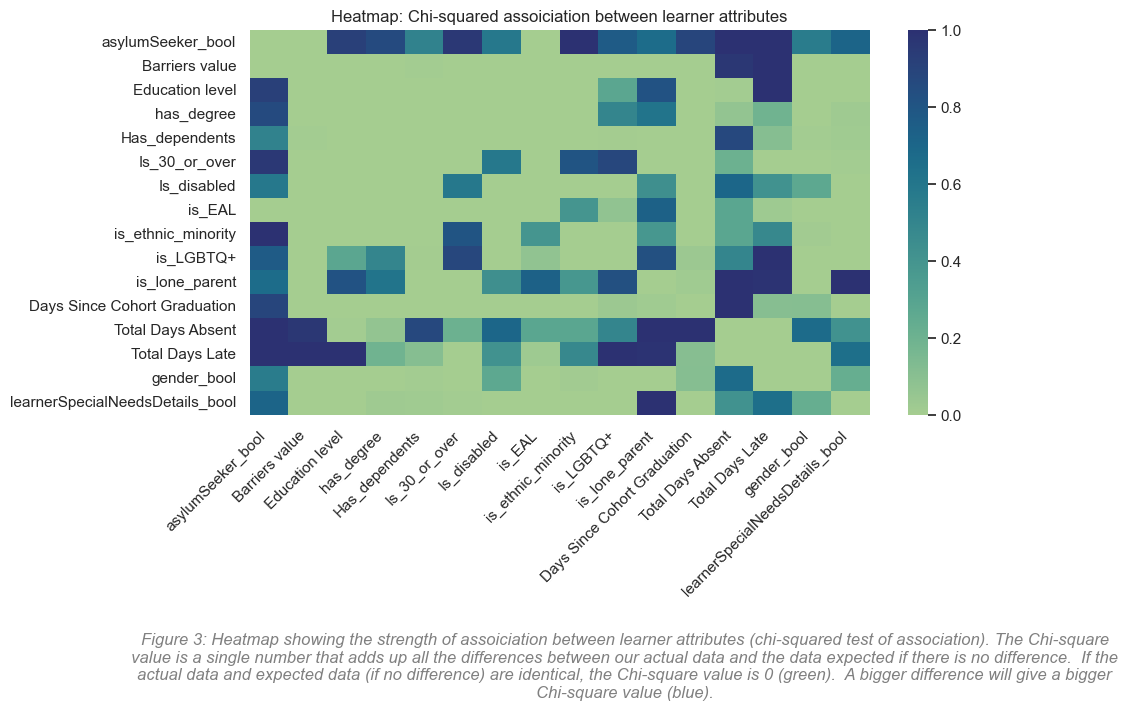

In [1179]:
plt.figure(figsize=(10, 5))
sns.heatmap(chisqmatrix, cmap="crest")

# show the graph
plt.ylabel("")
plt.xlabel("")
plt.rcParams.update({'font.size': 8})
plt.xticks(rotation=45, ha="right")
plt.title("Heatmap: Chi-squared assoiciation between learner attributes")
txt="Figure 3: Heatmap showing the strength of assoiciation between learner attributes (chi-squared test of association). The Chi-square value is a single number that adds up all the differences between our actual data and the data expected if there is no difference.  If the actual data and expected data (if no difference) are identical, the Chi-square value is 0 (green).  A bigger difference will give a bigger Chi-square value (blue)."
plt.figtext(0.5, -0.45, txt, wrap=True, horizontalalignment='center', fontsize=12, color="0.5", style='italic')
plt.show()

The heatmap above shows that there are some interesting associations between barriers:
- There is a strong relationship between asylum seeker value and several of the barrier fields. NOTE: The number of asylum seelers is small so more data would need to be collected to understand this association.
- There is a relationship between the barriers value and total days absent or late
- There is a relationship between status as a lone parent and disclosing other special needs.

To understand these relationships properly more data analysis needs to be completed.

Below are two more figures exploring the barriers value for Generation learners.

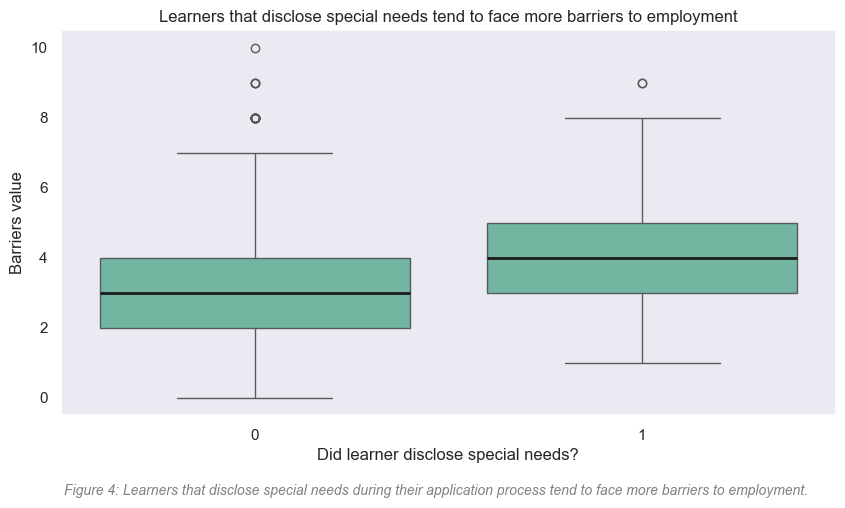

In [1312]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

sns.boxplot(data=gen_df, 
            x="learnerSpecialNeedsDetails_bool",
            y="Barriers value",
            ax=axs, 
            # meanprops={'visible': True, 'color': 'r', 'ls': '-', 'lw': 2},
            medianprops={'visible': True, 'color': 'k', 'ls': '-', 'lw': 2}, 
            # showmeans=True, meanline=True, showfliers=False, showbox=False, showcaps=False, zorder=10
           )

plt.xlabel("Did learner disclose special needs?")
plt.title("Learners that disclose special needs tend to face more barriers to employment")
txt="Figure 4: Learners that disclose special needs during their application process tend to face more barriers to employment."
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10, color="0.5", style='italic')
plt.show()

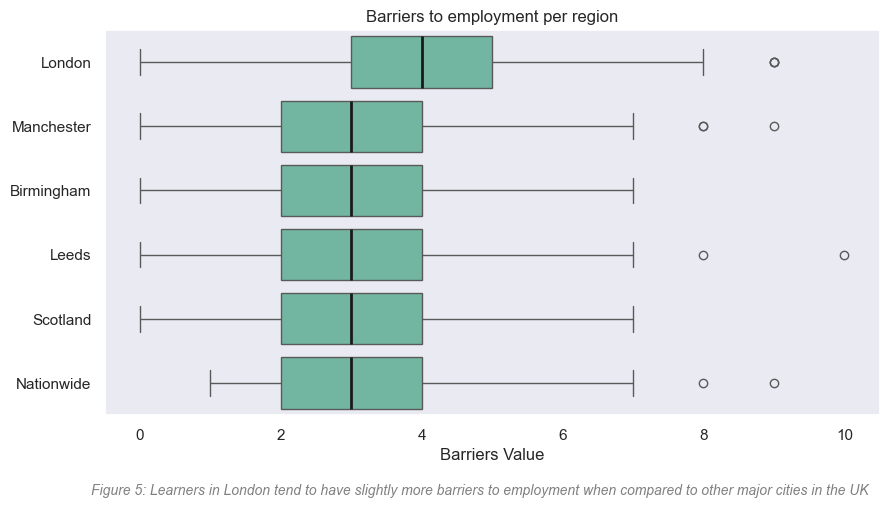

In [1313]:
fig, axs = plt.subplots(1, 1, figsize=(10,5))

sns.boxplot(data=gen_df, 
            y="Cohort_City",
            x="Barriers value",
            ax=axs, 
            medianprops={'visible': True, 'color': 'k', 'ls': '-', 'lw': 2}, 
           )

plt.xlabel("Barriers Value")
plt.ylabel("")
plt.title("Barriers to employment per region")
txt="Figure 5: Learners in London tend to have slightly more barriers to employment when compared to other major cities in the UK"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10, color="0.5", style='italic')
plt.show()

#### Are there program-specific trends in the specific barriers?

In [1314]:
# Create a stacked bar chart:

@interact
def stacked_barchart(barrier=["Is_30_or_over", 
                              "Is_disabled", 
                              "is_EAL", 
                              "is_ethnic_minority", 
                              "is_LGBTQ+", 
                              "is_lone_parent", 
                              "is_low_socio_econ",
                              "is_unempl_12+_mths",
                              "is_unemployed_pre_gen",
                              "is_unsatisfied_empl_pre_gen",
                              "learnerSpecialNeedsDetails_bool",
                              "gender_bool"
                             ]):
    # import libraries
    import matplotlib.patches as mpatches
    
    # set the figure size
    fig = plt.figure(figsize=(10, 5))
    # ax = plt.subplot(111)
    
    # from raw value to percentage
    grads_per_programme_count = gen_df.groupby('ProgramName')['Student_ID'].count().reset_index()
    barrier_per_programme = gen_df.groupby('ProgramName')[barrier].sum().reset_index()
    barrier_per_programme[barrier] = [i / j * 100 for i,j in zip(barrier_per_programme[barrier], grads_per_programme_count['Student_ID'])]
    grads_per_programme_count['Student_ID'] = [i / j * 100 for i,j in zip(grads_per_programme_count['Student_ID'], grads_per_programme_count['Student_ID'])]
    
    # bar chart 1 -> top bars (group of 'smoker=No')
    bar1 = sns.barplot(y="ProgramName",  x="Student_ID", data=grads_per_programme_count, color='darkblue', order=barrier_per_programme["ProgramName"])
    
    # bar chart 2 -> bottom bars (group of 'smoker=Yes')
    bar2 = sns.barplot(y="ProgramName", x=barrier, data=barrier_per_programme, color='lightblue')
    
    # add legend
    top_bar = mpatches.Patch(color='darkblue', label=f'Not {barrier}')
    bottom_bar = mpatches.Patch(color='lightblue', label= f'{barrier}')
    plt.legend(handles=[top_bar, bottom_bar], bbox_to_anchor=(1.04, 1), loc="upper left")
    
    # show the graph
    plt.ylabel("")
    plt.xlabel("% of Students")
    plt.rcParams.update({'font.size': 35})
    plt.show()

interactive(children=(Dropdown(description='barrier', options=('Is_30_or_over', 'Is_disabled', 'is_EAL', 'is_e…

Figure 6 above is showing how a particular barrier or learner characteristic is represented across the different Generation programmes. Here are some key findings:
- The AWS programme seems to attract a much younger crowd than the other programmes - is there room to expand recruitment activity for applicants over 30?
- Women + nonbinary individuals make up less than 40% of all technical programmes.

#### Does gender impact employment outcomes? Are there any interesting trends in the genders of the learners?

In [1315]:
def Sankey_data_preprocessing(feature_list, data, stop_points = None):
    # replace with feature_list
    
    source_ = [] 
    target_ = [] 
    value_ = []
    int_keys = {}
    temp_list = []
    
    # Create a complete list of sources and targets and convert to a dict:
    for x in feature_list:
        temp_list += gen_df[x].value_counts().index.tolist()

    for x in temp_list:
        int_keys[x] = temp_list.index(x)

    # Loop through each source feature in the provided list source_feature_list. 
    # Each loop represents one portion of the sanksey diagram:
    
    for i in range(len(feature_list)-1):
        # Make a list of the source values and target values for this part of the sankey diagram:
        source_values_str = data[feature_list[i]].value_counts().index.tolist()
        target_values_str = data[feature_list[i+1]].value_counts().index.tolist()

# fix the reference to target feature
        for source_val in source_values_str:
            for target_val in target_values_str:
                count_temp = data[data[feature_list[i+1]]==target_val].groupby(data[feature_list[i]]==source_val)[feature_list[i+1]].count()
                if True in count_temp:
                    count_temp = count_temp[True]
                    source_.append(int_keys[source_val])
                    target_.append(int_keys[target_val])
                    value_.append(count_temp)

    labels_str = temp_list
    
    return source_, target_, value_, labels_str

In [1316]:
def Sankey_plot(source_, target_, value_, labels=None, title_text_=None):
    
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
          color = "blue"
        ),
        link = dict(
          source = source_,
          target = target_,
          value = value_,
          hovercolor=["midnightblue", "lightskyblue", "gold", "mediumturquoise", "lightgreen", "cyan"],
      ))])

    # #Specify color for nodes 0, 1, 2, 3 and 4 in both source and target nodes
    # color_for_nodes = ["blue","blue","green","blue","blue", "blue", "blue", "blue", "blue", "blue","blue", "blue", "blue", "blue", "blue", "blue", "blue", "blue", "blue"]
    # fig.update_traces(node_color = color_for_nodes)
    
    fig.update_layout(title_text=title_text_, font_size=14)
    fig.show(renderer="iframe") 

In [1317]:
data = gen_df
input_features= ["gender", "Employment_Status"]

source_, target_, value_, labels = Sankey_data_preprocessing(input_features, data, stop_points_)
Sankey_plot(source_, target_, value_, labels=labels, title_text_= "Employment outcomes per gender")

#### Female + Non-binary students are fewer than men in Generation tech programmes
The figure above (Figure 7) shows that Generation recruits less women and non-binary people (501) than men (1150) for its tech bootcamps by a significant margin. The good news is that the Female, Non-binary graduates have a similar success rate in finding employment post-bootcamp. 

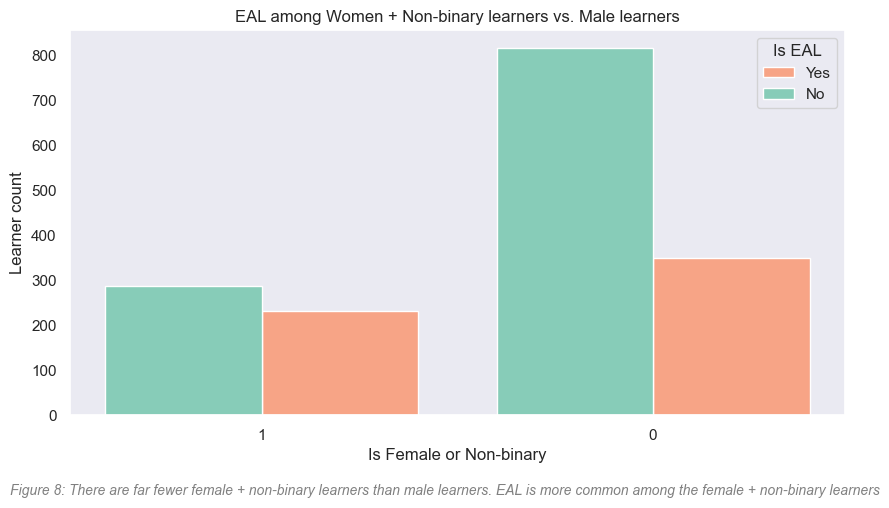

In [1321]:
# How does EAL relate to post-bootcamp placement?
plt.figure(figsize=(10, 5))

sns.histplot(x=gen_df["gender_bool"].astype(str), 
             hue=gen_df["is_EAL"],
             multiple="dodge",
             shrink=.8)

plt.legend(('Yes', 'No'), title="Is EAL", loc='upper right')
plt.ylabel("Learner count")
plt.xlabel("Is Female or Non-binary")
plt.title("EAL among Women + Non-binary learners vs. Male learners")
txt="Figure 8: There are far fewer female + non-binary learners than male learners. EAL is more common among the female + non-binary learners"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10, color="0.5", style='italic')
plt.show()

Nearly half of female students are EAL while just 30% of the Male students are EAL. Why are female generation students more likely to be EAL than male students? 

68.5% of Generation's tech bootcamp learners are men 

Despite major efforts to attract female and non-binary learners ontthere is much room for improvement. 

In [1296]:
EAL_genders = gen_df[gen_df["is_EAL"]==1]["is_EAL"].groupby(gen_df["gender"]).count()
nonEAL_genders = gen_df[gen_df["is_EAL"]==0]["Student_ID"].groupby(gen_df["gender"]).count()

EAL_gender_df = pd.concat([EAL_genders, nonEAL_genders], axis=1)
EAL_gender_df.rename(columns = {"is_EAL":"Is EAL", "Student_ID":"Is not EAL"}, inplace=True)

EAL_gender_df.style.background_gradient(axis=None, low=0.5, high=1)

,Is EAL,Is not EAL
gender,,
Female,226,275
Male,341,811
Non-binary,5,11
Other,2,4
Prefer not to say,4,1


#### Bonus Question! Does graduation month impact 180D employment rate?
Recruitment is something that fluctuates throughout the year. Is a generation grad more likely to get hired within 6 months if they graduate during a particular time of year?

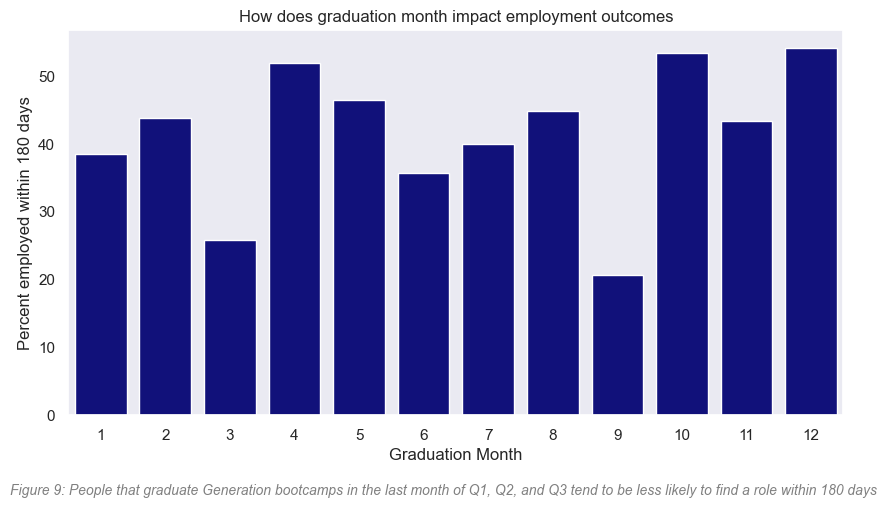

In [1320]:
plt.figure(figsize=(10, 5))

grads_per_graduation_month = gen_df.groupby('Graduation_month')['Student_ID'].count().reset_index()
num_placed_at180_per_month = gen_df.groupby('Graduation_month')["Employed_within_180D"].sum().reset_index()
num_placed_at180_per_month["Employed_within_180D"] = [i / j * 100 for i,j in zip(num_placed_at180_per_month["Employed_within_180D"], grads_per_graduation_month['Student_ID'])]
grads_per_graduation_month['Student_ID'] = [i / j * 100 for i,j in zip(grads_per_graduation_month['Student_ID'], grads_per_graduation_month['Student_ID'])]

sns.barplot(x="Graduation_month", y="Employed_within_180D", data=num_placed_at180_per_month, color='darkblue')
plt.ylabel("Percent employed within 180 days")
plt.xlabel("Graduation Month")
plt.title("How does graduation month impact employment outcomes")
txt="Figure 9: People that graduate Generation bootcamps in the last month of Q1, Q2, and Q3 tend to be less likely to find a role within 180 days"
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=10, color="0.5", style='italic')
plt.show()

## Summary

This EDA has surfaced the following insights:
1. Most Generation learners are joining the generation programme with 3-4 barriers to employment and the number of barriers a learner has follows a normal distribution. This is consistent with Generations mission and shows that the admissions process seems to be functioning well. 
2. Depression and anxiety are the most common special need self-reported by generation learners. These types of mental health needs are not necesarily captured in other barriers metrics and more work could be done to understand how these conditions impact the learner experience
3. The AWS programme seems to attract a much younger crowd than the other programmes - is there room to expand recruitment activity for applicants over 30?
4. Women + nonbinary individuals make up less than 40% of all technical programmes. Approximately half of female students are EAL while just 30% of the Male students are EAL.
5. There seem to be some relationship between graduation month and likelihood of being employed within 180 days. More work needs to confirm.


## Next steps

Direction for further analysis, questions to consider:

- Why are AWS learners much youger (on average) than the learners in other bootcamps. Is there room to expand admissions among learners over 30?
- What can Generation do to minimise the gap in Female+Non-binary learners and Male learners?
- Why are female generation students more likely to be EAL than male students?
- Is there actually a relationship between graduation month and likelihood of being employed within 180 days? If yes, how should this impact cohort planning?